### Outline for CNNs notebook

0. Introduction
1. Recall general architecture of MLPs
2. High-level overview of CNN architecture
    - Input layer
    - Convolutional layer
    - Pooling layer
    - Fully connected layer
3. Convolutions
    - What kind of data do we use convolutions on? (images, time series, ordered data in general)
    - What is a convolution good for?
        - Finite differences to approximate derivatives in time series
        - Moving average to smooth out noise
        - Convolution with dirac delta to extract a part of a signal
        - Convolution of probability distributions
        - Edge detection in images
        - Feature extraction in general by convolution with a filter/kernel
4. Convolutional layer
    - Convolution operation
    - Stride
    - Padding
    - Number of filters
    - Activation function
5. Pooling layer
    - Max pooling
    - Average pooling
    - Global average pooling
6. Fully connected layer
7. CNNs in practice
    - Example of a CNN architecture
    - Example of a CNN training
    - Example of a CNN application

---

## 0. Introduction

### Some interesting types of ML problems

Here are six machine learning problems that demonstrate the kinds of tasks ML models are used for. Try to think about what the input data looks like for each:

##### Structured data problems
1. **Predicting housing prices** from a dataset containing numerical and categorical information about homes (e.g., square footage, number of bedrooms, neighborhood).
2. **Detecting credit card fraud** based on transaction metadata (e.g., amount, location, time, frequency).
3. **Recommending loans** or predicting default based on financial and demographic features.

##### Unstructured data problems
4. **Classifying handwritten digits** from images (e.g., MNIST dataset).
5. **Detecting objects in photographs** (e.g., identifying a cat or a stop sign in a picture).
6. **Translating spoken language** into text or another language (e.g., speech recognition and machine translation).

As we’ll see, tasks 1–3 involve well-defined, structured information. Tasks 4–6 involve messy, high-dimensional data that doesn’t fit neatly into rows and columns — and yet they are central to many modern AI systems.

---

### Structured vs. Unstructured Data

**Structured data** is information that comes in a predefined format, where each input sample has the same number and type of features. In the examples above, the housing price, credit card, and loan problems all involve structured data — we can represent each data point as a vector in a spreadsheet or a row in a database. It's easy to parse, search, and feed into traditional machine learning models.

**Unstructured data**, by contrast, lacks a rigid format. An image is just an array of pixel values, but their spatial relationships carry meaning. Similarly, audio is a continuous waveform, and natural language is a sequence of words with complex dependencies. In the digit classification and object detection problems, we can’t simply feed the raw pixel values into a linear model and expect it to work — we need models that can **extract structure** from unstructured input.

In summary:
- Structured data has fixed fields and a consistent schema.
- Unstructured data is raw, complex, and rich in information, but harder to interpret algorithmically.

---

### Humans vs. Machines: The Moravec Paradox

There’s a fascinating and somewhat counterintuitive fact in the history of artificial intelligence, known as the **Moravec Paradox**:

> *"It is comparatively easy to make computers exhibit adult-level performance on intelligence tests or playing chess, but difficult or impossible to give them the skills of a one-year-old when it comes to perception and mobility."*

This paradox was articulated in the 1980s by **Hans Moravec**, along with Marvin Minsky and others. The core idea is that **the things humans find effortless — like recognizing faces, reading handwriting, or walking around obstacles — are actually the hardest for machines**, while tasks that we struggle with — like performing statistical inference or solving equations — are much easier for computers.

This distinction largely boils down to **structured vs. unstructured data**:
- Humans are naturally wired (via evolution and experience) to process unstructured sensory inputs — vision, sound, language — with incredible speed and robustness.
- Computers excel at symbolic, logic-based, and numerical operations — especially with clean, structured input.

Historically, early machine learning efforts focused on structured data because that was where traditional algorithms worked well. But recent advances in **deep learning** — especially convolutional neural networks — have enabled machines to make huge strides in understanding and working with unstructured data.

In this lecture, we begin our journey into this new domain by looking at **images**, which are a prototypical form of unstructured data.

---

# 1. Recall general architecture of MLPs

In the previous lecture, we explored the XOR problem and discovered why simple perceptrons are insufficient for solving it, necessitating the use of multilayer perceptrons (MLPs). Let's recall the general architecture of an MLP.

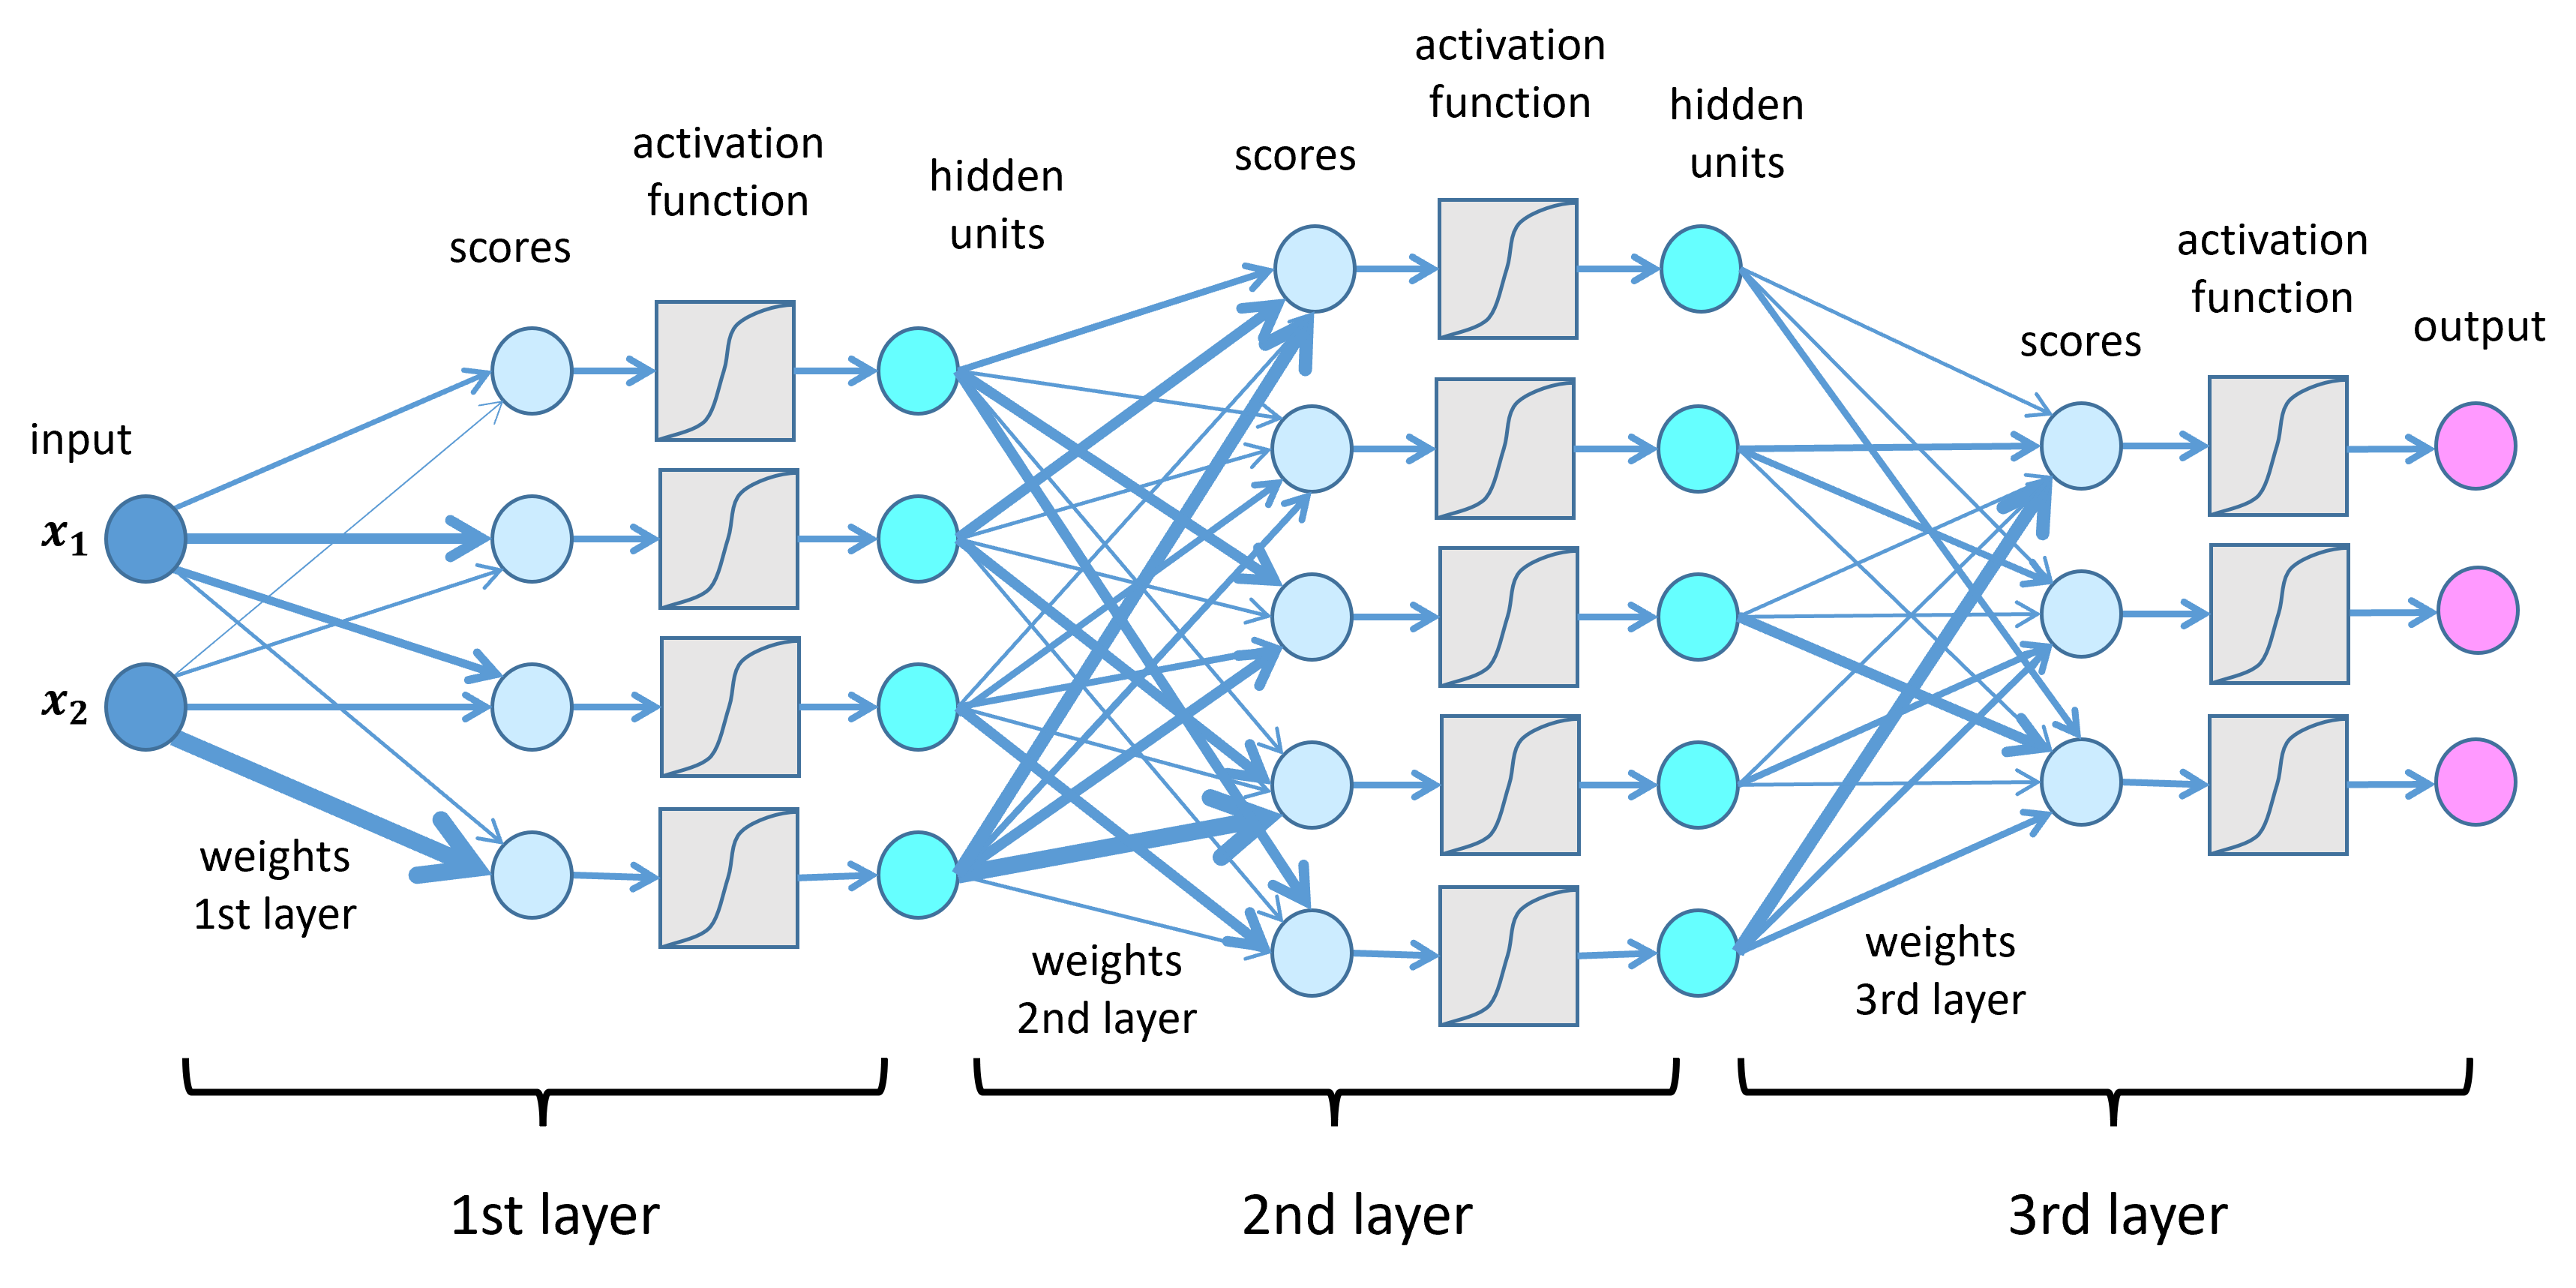

In [4]:
from IPython.display import Image, display

display(Image('assets/Neural networks - Lamarr Institute.png'))

The diagram above shows a Multilayer Perceptron with:
- Input layer: 2 neurons ($x_1$, $x_2$)
- Hidden layer 1: 4 neurons
- Hidden layer 2: 5 neurons
- Output layer: 3 neurons

Each connection between neurons represents a weight parameter that the network learns during training. The thickness of the arrows represents the magnitude of the weights (analogous to how synapses have different strengths in biological neural networks).

The MLP processes data by passing it through these layers sequentially:
- From each layer, the data is first multiplied by the weights and aggregated to form a bunch of scores (weighted sums).
- Then, the scores are passed through an activation function (like ReLU, Sigmoid, or Tanh) to introduce non-linearity. In fact, the picture above visualizes a sigmoidal activation function, such as the logistic function $$\sigma(z) = \frac{1}{1 + e^{-z}},$$ or the hyperbolic tangent function $$\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}.$$
- The two operations above together constitute a single layer of the network. 

The final layer above is the output layer, which produces the final predictions of the network. For example, if we are using the neural network for a multi-class classification task with $3$ classes, the output layer will have $3$ neurons, each representing the probability of the input belonging to a particular class, and these probabilities would be obtained by taking the last bunch of scores and passing them through a softmax function.

### ReLU activation function
The power and flexibility of neural networks comes in large part from the non-linear activation functions. Note that $\sigma$ has range $(0, 1)$ and $\tanh$ has range $(-1, 1)$. 

A very popular activation function (of a different flavor from the previous two) is the Rectified Linear Unit (ReLU), which is defined as $$\text{ReLU}(z) = \max(0, z).$$
The ReLU function is computationally efficient and has been shown to work well in practice; it is used in many state-of-the-art neural networks.

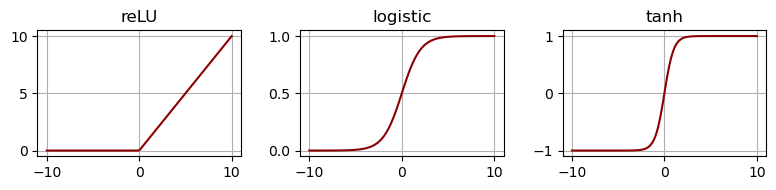

In [5]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

# python let's you define functions in a very simple way:
def reLU(x):
    return np.maximum(0, x)

def logistic(x):
    return 1 / (1 + np.exp(-x))

# Define a list of functions and names
activations = [('reLU', reLU), 
               ('logistic', logistic), 
               ('tanh', np.tanh)]

# Define the input range
x = np.linspace(-10, 10, 100)

# loop over the list for plotting
fig, axes = plt.subplots(1, 3, figsize=(8, 2))
for i, (name, f) in enumerate(activations):
    axes[i].plot(x, f(x), c='darkred')
    axes[i].set_title(f'{name}')
    axes[i].grid(True)
plt.tight_layout()
plt.show()

## 2. High-level overview of CNN architecture
Suppose we are working with an image classification task. Thus, we want to feed in an image as input and obtain a class label as output. (For this, we will have a pre-defined list of class labels, such as "cat", "dog", "car", etc.)

In such a scenario, the architecture of a CNN would look something like this:
1. **Input layer**: The input to the network is an image, stored as a tensor of shape `(channels, height, width)`. 
    - For color images, we typically have `channels = 3`, for Red, Green, and Blue (RGB). 
    - Alternatively, grayscale images have `channel = 1`, which represents pixel intensity.
2. **Convolutional layer**: The convolutional layer is the core building block of a CNN. 
    - It applies a set of *filters* to the input image, each of which detects a particular "feature" (e.g. edges, texture). 
    - These filters are defined by weights, which are learned during model training. 
    - The outputs of the convolutional layer are called *feature maps*; they are tensors with the same spatial dimension, but with one channel for each filter. 
    - These feature maps are then passed through an activation function (like ReLU) to introduce non-linearity.
    - **Fact**: The act of "applying" the filter is a linear operation called convolution, and convolutional layers can in fact be understood as usual fully connected layers, but with a particular weight structure in which most weights are zero, and the non-zero weights represent the filter values.
3. **Pooling layer**: Every convolutional layer is followed by a pooling layer to reduce model complexity and guard and overfitting.
    - It reduces the spatial dimensions of the incoming feature maps, resulting in a smaller representation of the learned features. 
    - The pooling operation involves applying a simple function (like max or average) to sub-regions of the feature map. In particular, there are no weights to learn in a pooling layer.
    - The output of the pooling layer is a "downsampled" version of the input feature map, with reduced spatial dimensions but the same number of channels as the input.
- **Fully connected layer**: After several convolutional and pooling layers, the final output of the network is typically fed through a multi-layer perceptron.
    - It takes the output of the last pooling layer and flattens it into a 1D array.
    - This 1D array is then passed through an MLP in which each layer is fully connected to the next. Of course, these connections have weights that are learned during training.
    - Applying a softmax function to the output of the MLP gives the final class probabilities.

Given below is depiction of the CNN architecture (with only one convolutional layer and one pooling layer) applied to an image classification task. Note that the convolutional and pooling layers have the effect of converting the raw input image tensor into another tensor that has somehow absorbed the important features of the image. This tensor is then passed through a fully connected layer to make the final prediction.

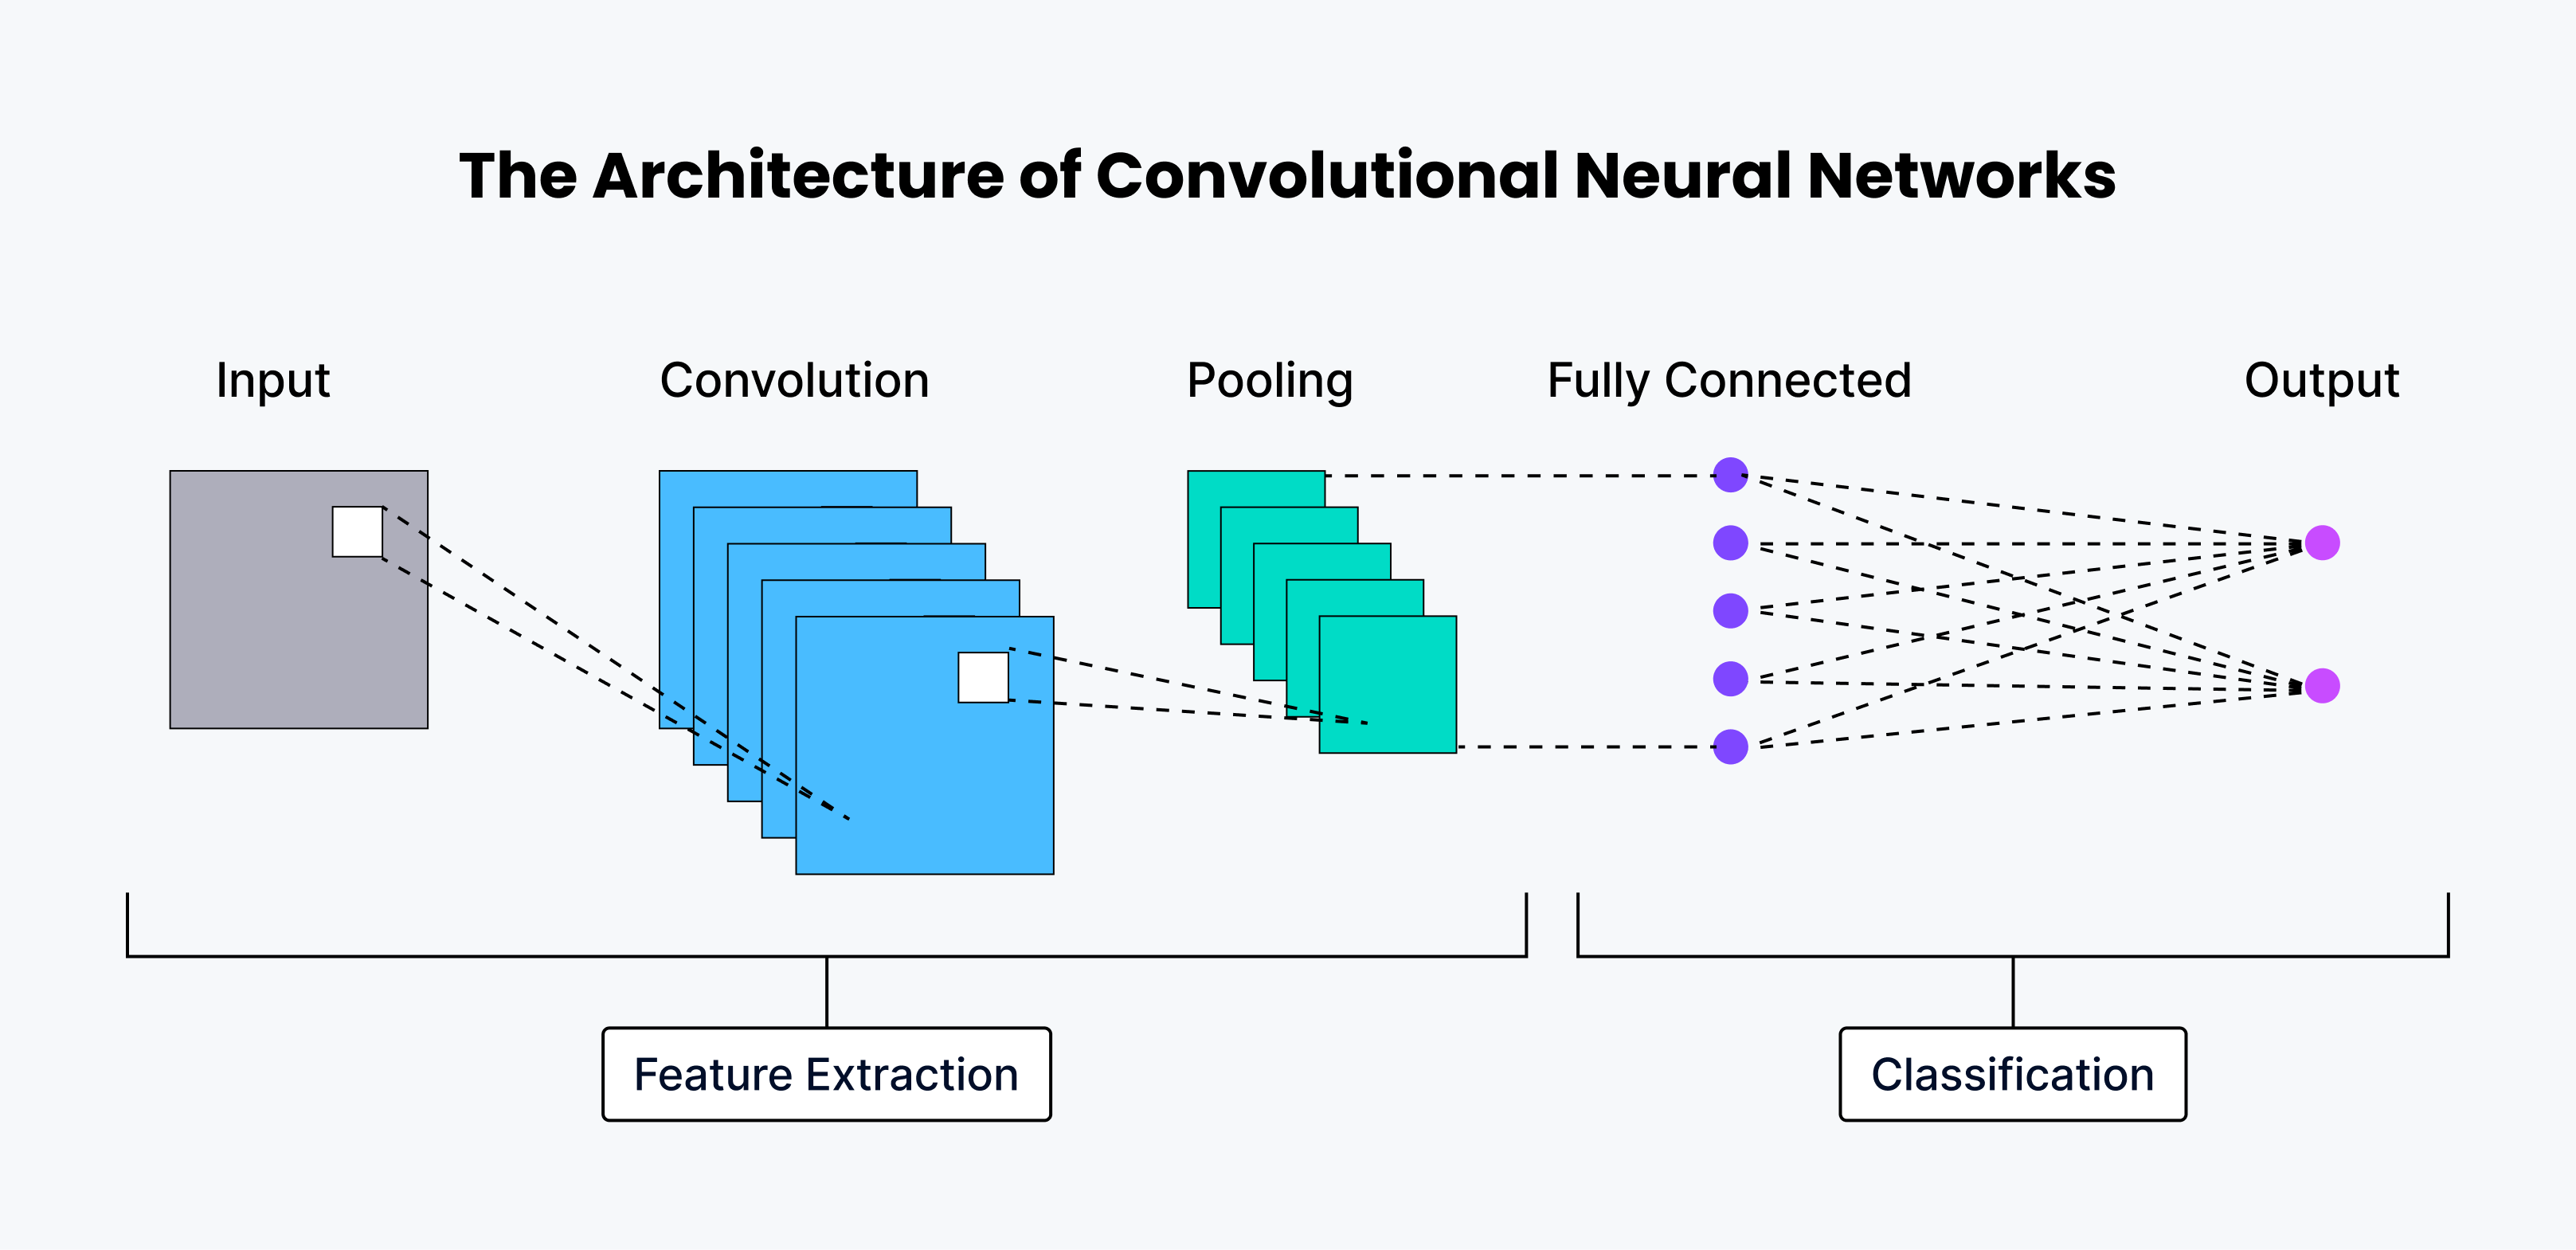

In [6]:
display(Image('assets/CNN-architecture-Zilliz.png'))

## 3. Convolutions

Convolutions are a particular type of mathematics operation performed on two functions $f$ and $g$ (from some set to another set), to produce a third function $f*g$ (with possibly different domain from $f$ and $g$). 

To understand convolutions, I want to work with a few different classes of functions to see how convolutions work in each case:
- Functions from a finite set of time steps to $\mathbb{R}$; these are time series (example stock prices).
- Functions from $\mathbb{R}$ to $\mathbb{R}$.
- Functions of the form $f: \{ \textup{ Pixel grid } \} \to [0,1]$; these are (grayscale) images, where the output represents pixel intesity (normalized to lie in $[0,1]$)!

Note that in each of the above cases, there is a natural arrangement or ordering of the points in the domain which allows us to ask questions about how the function behaves "near" a point. To answer these questions, we often resort to convolutions.

### Using dot products to get behavior near a point
The basic idea is as follows.
- Start with the vector or function $f$ that you want to understand, and the point $t$ in the domain where you want to understand some local behavior.
- Consider a small window of points around $t$, and choose values for all points in this window. Here, small is meant relative to the domain of $f$.
- Extend your selection of values into a vector or function $g$ of the same shape as $f$ by setting all other values to $0$.
- Take the dot product of $f$ and $g$ (which we here denote by $\langle f, g \rangle$) to get a single number that represents the local behavior of $f$ near $t$. The meaning of "dot product" depends on the type of function $f$ and $g$:
    - For time series (i.e. sequences of real numbers that are eventually $0$), the dot product is the sum of the products of the corresponding values of $f$ and $g$:
    \begin{equation*}
        \langle f , g \rangle = \sum_{i = 1}^{\infty} f(i) g(i).
    \end{equation*}
    - For functions from $\mathbb{R}$ to $\mathbb{R}$, the dot product is the integral of the product of the two functions:
    \begin{equation*}
        \langle f , g \rangle = \int_{-\infty}^{\infty} f(x) g(x) \, dx.
    \end{equation*}
    - For functions defined on a pixel grid, the dot product is again the sum of the products over the pixels:
    \begin{equation*}
        \langle f , g \rangle = \sum_{\mathbf{p} \in \textup{pixels}} f(\mathbf{p}) g({\mathbf{p}}).
    \end{equation*}


### Convolutions as a family of dot products
The above situation does not yet describe a convolution, because it only gives us the behavior of $f$ near a single point $t$ in the form of a scalar. Note that the window of values chosen by us is located near $t$ (often-times, it is centered at $t$), and $g$ is zero outside this window. 

The idea now is that we can repeat the above process for every point $t$ in the domain by sliding the window along the domain so that it is centered at $t$. 
For example:
- In the time series case, we can slide the window by $t$, which amounts to replacing $g(x)$ by $g(t - x)$. Thus, the dot product at $t$ (which is the output of the convolution at $t$) is:
\begin{equation*}
    (f * g)(t) = \sum_{i = 1}^{\infty} f(i) g({t-i}).
\end{equation*}

- In the case of functions from $\mathbb{R}$ to $\mathbb{R}$, we can slide the window by $t$, which amounts to replacing $g(x)$ by $g(t - x)$. Thus, the dot product at $t$ (which is the output of the convolution at $t$) is:
\begin{equation*}
    (f * g)(t) = \int_{-\infty}^{\infty} f(x) g(t - x) \, dx.
\end{equation*}
- In the case of functions defined on a pixel grid, sliding the window by a vector $\mathbf{v} = (x,y)$ amounts to replacing $g(\mathbf{t})$ by $g({\mathbf{t}- \mathbf{v}})$ (NOTE: here, $\mathbf{t}$ is a 2d-vector representing the pixel position in the array, so the formula makes sense). The dot product in this case is a sum over the pixels:
\begin{equation*}
    (f * g)(\mathbf{t}) = \sum_{\mathbf{v} \in \{\textup{pixels}\}} f(\mathbf{v}) g(\mathbf{t} - \mathbf{v}).
\end{equation*}

### Examples with one-dimensional data

#### Example 1: Moving averages of stock prices

We can visualize the NVDA stock as a **time series**, which basically an ordered list of real numbers indexed by date. Equivalently, you can think of the stock data as a function from the "dateline" to $\mathbb{R}$. 

Here is a visualization of the stock price from 2014 to 2024.

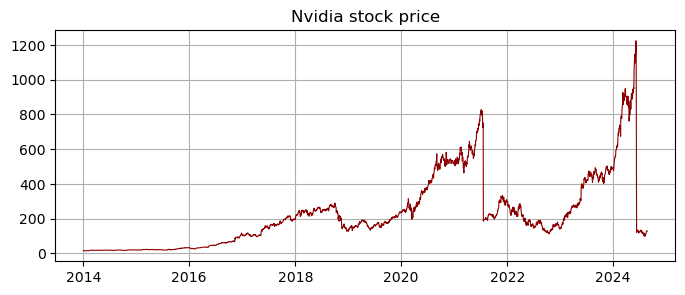

In [7]:
import pandas as pd
nvda_stock = pd.read_csv('assets/NVDA_stock.csv')
# use the date as the index
nvda_stock['date'] = pd.to_datetime(nvda_stock['date'])
nvda_stock.set_index('date', inplace=True)
# plot close price of NVDA as a time series
plt.figure(figsize=(8, 3))
plt.plot(nvda_stock['close'], c='darkred', linewidth=0.8)
plt.title('Nvidia stock price')
plt.grid(True)
plt.show()

Suppose we want to get rid of the small variations in the stock price and only keep the long-term trends. One way to replace each stock price by its average over the past $n$ days. That is, we seek a new function $f_n(t)$ whose value at $t$ equals the average stock price over the interval $[t-n, t]$.

We can accomplish this by applying the **$n$-day moving average** filter:
\begin{equation*}
    g_n(x) = \begin{cases}
        \frac{1}{n} & \text{if } 0 \leq x < n, \\
        0 & \text{otherwise}.
    \end{cases}
\end{equation*}
That is, $g_n$ is a function that is $1/n$ on the interval $[0, n)$ and $0$ elsewhere. It follows that for any $t$, the translated function $g_n(t-x)$ is $1/n$ on the interval $[t-n, t]$ and $0$ elsewhere. Thus, for any $t$ and any date $i$, we have:
\begin{equation*}
    f(i)g_n(t-i) = \begin{cases}
        \frac{f(i)}{n} & \text{if } t-n \leq i \leq t, \\
        0 & \text{otherwise}.
    \end{cases}
\end{equation*}
Summing over all $i$ gives the $n$-day moving average of the stock price at date $t$, which is the output of the convolution at $t$:
\begin{align*}
    (f * g_n)(t) & = \sum_{i = 0}^{n-1} f(i)g_n(t-i) \\
    & = \frac{f(t) + f(t-1) + \dotsb + f(t-n+1)}{n}.
\end{align*}

Let's illustrate this by taking moving averages of NVDA in the years 2022 and 2023. You will notice that longer time windows smooth out the stock price more.

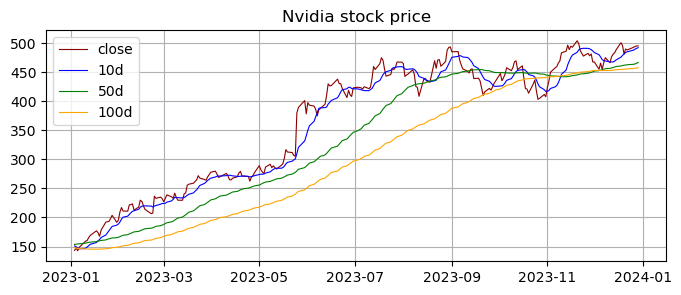

In [8]:
# Compute 10-day moving average and 50-day moving average
nvda_stock['10d'] = nvda_stock['close'].rolling(10).mean()
nvda_stock['50d'] = nvda_stock['close'].rolling(50).mean()
nvda_stock['100d'] = nvda_stock['close'].rolling(100).mean()

# plot close, 10d, 50d, and 100d moving averages for the year 2023
plt.figure(figsize=(8, 3))
plt.plot(nvda_stock['close']['2023'], c='darkred', linewidth=0.8, label='close')
plt.plot(nvda_stock['10d']['2023'], c='blue', linewidth=0.8, label='10d')
plt.plot(nvda_stock['50d']['2023'], c='green', linewidth=0.8, label='50d')
plt.plot(nvda_stock['100d']['2023'], c='orange', linewidth=0.8, label='100d')
plt.title('Nvidia stock price')
plt.legend()
plt.grid(True)
plt.show()

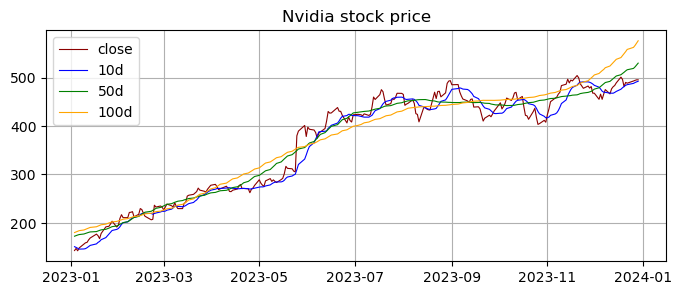

In [9]:
# Compute 10-day moving average and 50-day moving average
nvda_stock['10dc'] = nvda_stock['close'].rolling(10).mean().shift(-5)
nvda_stock['50d'] = nvda_stock['close'].rolling(50).mean().shift(-25)
nvda_stock['100d'] = nvda_stock['close'].rolling(100).mean().shift(-50)

# plot close, 10d, 50d, and 100d moving averages for the year 2023
plt.figure(figsize=(8, 3))
plt.plot(nvda_stock['close']['2023'], c='darkred', linewidth=0.8, label='close')
plt.plot(nvda_stock['10d']['2023'], c='blue', linewidth=0.8, label='10d')
plt.plot(nvda_stock['50d']['2023'], c='green', linewidth=0.8, label='50d')
plt.plot(nvda_stock['100d']['2023'], c='orange', linewidth=0.8, label='100d')
plt.title('Nvidia stock price')
plt.legend()
plt.grid(True)
plt.show()

#### Example 2: Differencing time series
Another very natural thing we might wish to do is to compute the change in stock price from one day to the next. This is called **differencing** the time series. To accomplish this, we apply the **difference filter**:
\begin{equation*}
    g(x) = \begin{cases}
        1 & \text{if } x = 0, \\
        -1 & \text{if } x = 1, \\
        0 & \text{otherwise}.
    \end{cases}
\end{equation*}
It follows that for any $t$ and date $i$, we have:
\begin{equation*}
    f(i)g(t-i) = \begin{cases}
        f(t) & \text{if } i = t, \\
        -f(t-1) & \text{if } i = t-1, \\
        0 & \text{otherwise}.
    \end{cases}
\end{equation*}
Summing over all $i$ gives the difference in stock price at date $t$, which is the output of the convolution at $t:
\begin{align*}
    (f * g)(t) & = \sum_{i = 0}^{1} f(i)g(t-i) \\
    & = f(t) - f(t-1).
\end{align*}

Let's illustrate this by differencing the stock price of NVDA in the year 2023. You will notice that the differenced stock price is much more volatile than the original stock price; the moral of the story is that even if there is a clear overall increasing trend, the stock price (hence, the returns) can still fluctuate wildly from day to day!

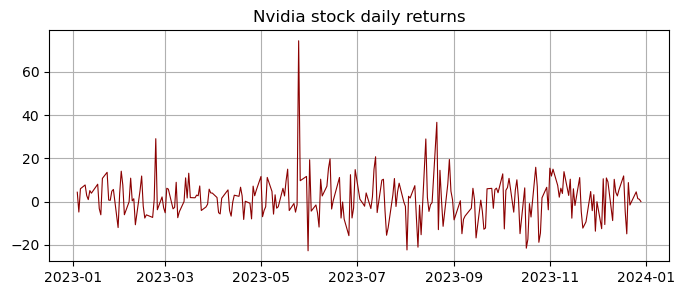

In [10]:
#plot the daily returns
plt.figure(figsize=(8, 3))
plt.plot(nvda_stock['close']['2023'] - nvda_stock['close']['2023'].shift(1), c='darkred', linewidth=0.8)
plt.title('Nvidia stock daily returns')
plt.grid(True)
plt.show()

#### Example 3: Convolution with a Dirac delta
Suppose $f : \mathbb{R} \to \mathbb{R}$ is an integrable function with anti-derivative $F$. For every $\epsilon > 0$, consider the function $g_{\epsilon}$ defined by:
\begin{equation*}
    g_{\epsilon}(x) = \begin{cases}
        \frac{1}{2\epsilon} & \text{if } -\epsilon \leq x \leq \epsilon, \\
        0 & \text{otherwise}.
    \end{cases}
\end{equation*}
Note that $g_{\epsilon}$ can be thought of as the probability density function of a random variable that is uniformly distributed on the interval $[-\epsilon, \epsilon]$, since
\begin{equation*}
    \int_{-\infty}^{\infty} g_{\epsilon}(x) \, dx = \frac{1}{2\epsilon} \int_{-\epsilon}^{\epsilon} \, dx = 1.
\end{equation*}
More generally, for any $t$, the translated function $g_{\epsilon}(t-x)$ is $1/(2\epsilon)$ on the interval $[t-\epsilon, t+\epsilon]$ and $0$ elsewhere, so that
\begin{equation*}
    \int_{-\infty}^{\infty} g_{\epsilon}(t-x) \, dx = \frac{1}{2\epsilon} \int_{t-\epsilon}^{t+\epsilon} \, dx = 1.
\end{equation*}
The convolution of $f$ with $g_{\epsilon}$ is then:
\begin{align*}
    (f * g_{\epsilon})(t) & = \int_{-\infty}^{\infty} f(x)g_{\epsilon}(t-x) \, dx \\
    & = \frac{1}{2\epsilon} \int_{t-\epsilon}^{t+\epsilon} f(x) \, dx \\
    & = \frac{ F(t+\epsilon) - F(t-\epsilon) }{2\epsilon}.
\end{align*}
This is a difference quotient! As $\epsilon \to 0$, the difference quotient converges to the derivative of $F$ at $t$. By the Fundamental Theorem of Calculus, this is $f(t)$, i.e.
\begin{equation*}
    \lim_{\epsilon \to 0} (f * g_{\epsilon})(t) = \lim_{\epsilon \to 0} \frac{ F(t+\epsilon) - F(t-\epsilon) }{2\epsilon} = f(t).
\end{equation*}
The **Dirac Delta function** $\delta$ is born out of the desire to pass the limit to the function $g_{\epsilon}$ insides the convolution, so that one could then write
\begin{equation*}
    f(t) = (f * \delta)(t) = \int_{-\infty}^{\infty} f(x) \delta(t-x) \, dx.
\end{equation*}
Unfortunately, this doesn't directly work, simply by noting that as $\epsilon \to 0$, the limit of $g_{\epsilon}$ would look like:
\begin{equation*}
    \lim_{\epsilon \to 0} g_{\epsilon}(x) = \begin{cases}
        \infty & \text{if } x = 0, \\
        0 & \text{otherwise}.
    \end{cases}
\end{equation*}
Well, a lot of folks are okay with this definition (plus the additional assumption that the integral over the whole real line is $1$), but it's clearly not a function. There are two ways to resolve this:
- View it as a "distribution" and not a function.
- Drop the function altogether and define a suitable *Dirac measure* on the real line, which assigns a measure of $1$ to any set containing $0$, and $0$ otherwise. 

**Remark**: The Dirac Delta is famous because of its role in physics. However, it also serves a fundamental purpose from a more abstract perspective. Namely, there are several natural spaces of functions that are closed under the convolution operation. In fact, convolution behaves just like multiplication on these spaces (associative, distributive, commutative, etc.) There's just one problem... these spaces may not have an identity element for this "multiplication" operation! Thus, the The Dirac Delta serves as the identity element for the convolution operation on these spaces (even if it's not actually a function, lol).

#### Example 4: Convolution of probability distributions
I won't say much about this, simply mention that if $X$ and $Y$ are two independent random variables with probability density functions $f$ and $g$, then the probability density function of $X + Y$ is the convolution of $f$ and $g$:
\begin{equation*}
    f_{X+Y}(x) = (f_X * f_Y)(x) = \int_{-\infty}^{\infty} f_X(x-y)f_Y(y) \, dy.
\end{equation*}
This is a fundamental result in probability theory. 

Watch the following masterpiece of a video by 3Blue1Brown for an incredibly clear explanation: https://www.youtube.com/watch?v=IaSGqQa5O-M

### Examples with images

#### Representing and working with images
Suppose we have now a grayscale image $I$ of `width = n` and `height = m`. In terms of data, $I$ can be understood then as the data of a collection of pixel intensities $I(i,j) \in [0,1]$, where $i$ is in `range(m)` and $j$ is in `range(n)`. In other words, giving an $m \times n$ grayscale is equivalent to giving a function 
\begin{equation*}
    I : \{0, 1, \dotsc, m-1\} \times \{0, 1, \dotsc, n-1\} \to [0,1].
\end{equation*}

In PyTorch, an image like the one above would typically be represented as a tensor of shape `(channels, height, width)`. 
- For grayscale images, `channels = 1`, and for RGB images, `channels = 3`.
- In our notation above, `height` corresponds to `m` and `width` corresponds to `n`.

Let's recall how to load and display images in PyTorch, using the MNIST dataset.

In [11]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

# Define a simple transform to convert images to tensors.
# Thie transforms the initial data (images, with pixel values from 0 to 255) to tensors (with pixel values from 0 to 1).
transform = transforms.ToTensor()

# Load MNIST from the local 'data' folder with download=False.
mnist_data = MNIST(root='assets/data', train=True, download=False, transform=transform)

# Create a DataLoader to sample a few images.
data_loader = DataLoader(mnist_data, batch_size=8, shuffle=True)

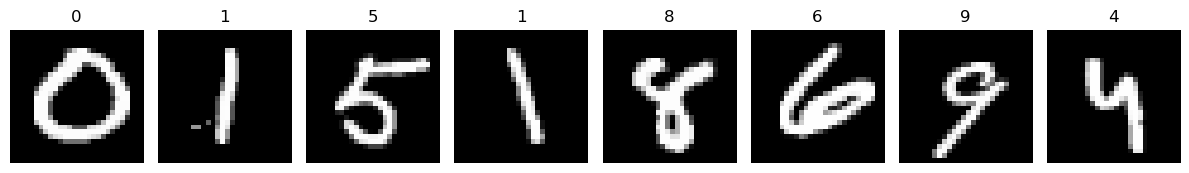

In [12]:
# Get one batch of images.
images, labels = next(iter(data_loader))

# Plot the images
fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i, ax in enumerate(axes):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(str(labels[i].item()))
    ax.axis('off')
plt.tight_layout()
plt.show()

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

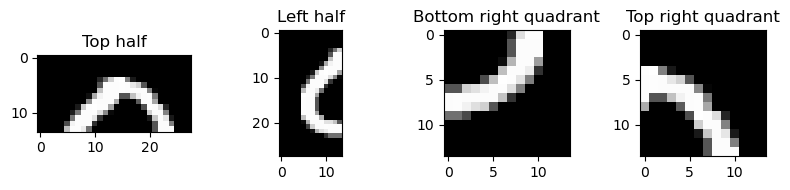

In [13]:
# print the image sizes and what they represent
img = images[0]
print(img)
print(f'Image shape: {img.shape}')
print(f'Channels: {img.shape[0]}')
print(f'Height: {img.shape[1]}')
print(f'Width: {img.shape[2]}')

#display parts of the image
fig, ax = plt.subplots(1, 4, figsize=(8, 2))
# top half
ax[0].imshow(img.squeeze().numpy()[:14, :], cmap='gray')
ax[0].set_title('Top half')
# left half
ax[1].imshow(img.squeeze().numpy()[:, :14], cmap='gray')
ax[1].set_title('Left half')
# bottom right quadrant
ax[2].imshow(img.squeeze().numpy()[14:, 14:], cmap='gray')
ax[2].set_title('Bottom right quadrant')
# top right quadrant
ax[3].imshow(img.squeeze().numpy()[:14, 14:], cmap='gray')
ax[3].set_title('Top right quadrant')
plt.tight_layout()
plt.show()

#### Example 1: Converting color images to grayscale
One way to convert a color image to grayscale is to take the average of the pixel intensities across the three color channels (Red, Green, Blue). This can be done by applying an **averaging filter**:
\begin{equation*}
    K = \frac{1}{3} \begin{bmatrix}
        1 & 1 & 1 \\
        1 & 1 & 1 \\
        1 & 1 & 1
    \end{bmatrix}.
\end{equation*}
The output of the convolution of this filter with the color image is a grayscale image, where each pixel intensity is the average of the pixel intensities across the three color channels.

Let's demonstrate this below by converting a color image to grayscale. 

Before resizing:
Murphy tensor shape: torch.Size([3, 1280, 960])
Anbu tensor shape: torch.Size([3, 1280, 960])
After resizing:
Murphy tensor shape: torch.Size([1, 3, 256, 256])
Anbu tensor shape: torch.Size([1, 3, 256, 256])


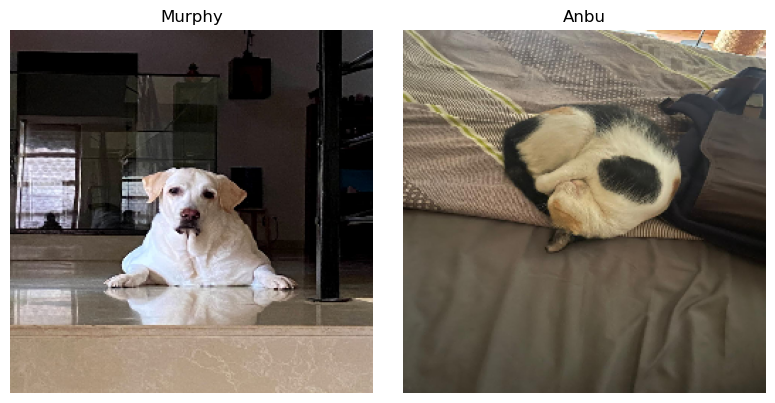

In [14]:
from PIL import Image as PILImage
# Open the images using PIL instead of IPython.display.Image
murphy = PILImage.open("assets/murphy.jpeg")
anbu = PILImage.open("assets/anbu.jpeg")

# Convert the images to tensors
murphy_tensor = transforms.ToTensor()(murphy)
anbu_tensor = transforms.ToTensor()(anbu)

# Display the tensor shapes
print(f'Before resizing:')
print(f'Murphy tensor shape: {murphy_tensor.shape}')
print(f'Anbu tensor shape: {anbu_tensor.shape}')

# Reshape them into 256x256 images for convenience
murphy_smol = F.interpolate(murphy_tensor.unsqueeze(0), size=256)
anbu_smol = F.interpolate(anbu_tensor.unsqueeze(0), size=256)

# Display the tensor shapes
print(f'After resizing:')
print(f'Murphy tensor shape: {murphy_smol.shape}')
print(f'Anbu tensor shape: {anbu_smol.shape}')

# Display the images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(murphy_smol.squeeze().numpy().transpose(1, 2, 0))
axes[0].axis('off')
axes[0].set_title('Murphy')
axes[1].imshow(anbu_smol.squeeze().numpy().transpose(1, 2, 0))
axes[1].axis('off')
axes[1].set_title('Anbu')
plt.tight_layout()
plt.show()

Now, let's apply the averaging filter to convert the color image to grayscale.

In [15]:
# Apply averaging filter to color channels
# Define the filter
avg_filter = torch.ones(1, 3, 1, 1) / 3

# Apply the filter to the images
murphy_grayscale = F.conv2d(murphy_smol, avg_filter)
anbu_grayscale = F.conv2d(anbu_smol, avg_filter)

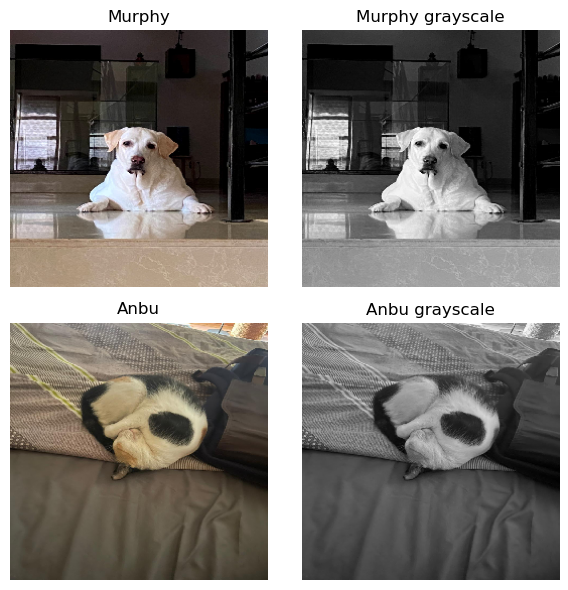

In [16]:
# Display the images along with their grayscale versions
fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax = ax.flatten()
ax[0].imshow(murphy_smol.squeeze().permute(1, 2, 0))
ax[0].set_title('Murphy')
ax[1].imshow(murphy_grayscale.squeeze(), cmap='gray')
ax[1].set_title('Murphy grayscale')
ax[2].imshow(anbu_smol.squeeze().permute(1, 2, 0))
ax[2].set_title('Anbu')
ax[3].imshow(anbu_grayscale.squeeze(), cmap='gray')
ax[3].set_title('Anbu grayscale')
# remove all grids and axes
for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()

#### Example 2: Edge detection in images
One of the most famous applications of convolutions in image processing is edge detection. The idea is to apply a filter to the image that highlights the edges in the image.  We can do this by applying a 3x3 filter that looks like this (here, applying means we slide the filter around the image and compute the dot product at each position).

Since edges are regions where the pixel intensity changes rapidly, we might expect to find an edge when the **difference** in pixel intensity between nearby pixels is large. Thus, we can use the **difference filter** to capture (say) large changes in pixel intensity along the vertical dimension, which would correspond to horizontal edges in the image. 

In general, one computes a filter $K_v$ to detect vertical edges and a filter $K_h$ to detect horizontal edges.
There are a few different popular choices:
1. The **Prewitt filter**: They are defined as:
\begin{equation*}
    K_v = \begin{bmatrix}
        -1 & 0 & 1 \\
        -1 & 0 & 1 \\
        -1 & 0 & 1
    \end{bmatrix}, \quad
    K_h = \begin{bmatrix}
        -1 & -1 & -1 \\
        0 & 0 & 0 \\
        1 & 1 & 1
    \end{bmatrix}.
\end{equation*}
2. The **Sobel filter**: They are defined as:
\begin{equation*}
    K_v = \begin{bmatrix}
        -1 & 0 & 1 \\
        -2 & 0 & 2 \\
        -1 & 0 & 1
    \end{bmatrix}, \quad
    K_h = \begin{bmatrix}
        -1 & -2 & -1 \\
        0 & 0 & 0 \\
        1 & 2 & 1
    \end{bmatrix}.
\end{equation*}

NOTE: In both these example, note that the the filter for detecting vertical edges $K_v$ looks like a row-wise differencing operator, while the filter for detecting horizontal edges $K_h$ looks like a column-wise differencing operator. Thus, they are able to detect pixel intensity changes in the vertical and horizontal directions, respectively!

Let's apply the Sobel filters to the grayscale images of Murphy and Anbu to detect edges.

In [17]:
# Define the Sobel filter for vertical edge detection
sobel_filter_v = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32)

# Define the Sobel filter for horizontal edge detection
sobel_filter_h = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32)

# Reshape the filters to match the expected shape for PyTorch's conv2d
sobel_filter_v = sobel_filter_v.view(1, 1, 3, 3)
sobel_filter_h = sobel_filter_h.view(1, 1, 3, 3)

# Apply vertical-edge detection filter
murphy_v = F.conv2d(murphy_grayscale, sobel_filter_v)
anbu_v = F.conv2d(anbu_grayscale, sobel_filter_v)

# Apply horizontal-edge detection filter
murphy_h = F.conv2d(murphy_grayscale, sobel_filter_h)
anbu_h = F.conv2d(anbu_grayscale, sobel_filter_h)

# Compute the magnitude of the gradient; this is another image!
murphy_vh = torch.sqrt(murphy_v**2 + murphy_h**2)
anbu_vh = torch.sqrt(anbu_v**2 + anbu_h**2)

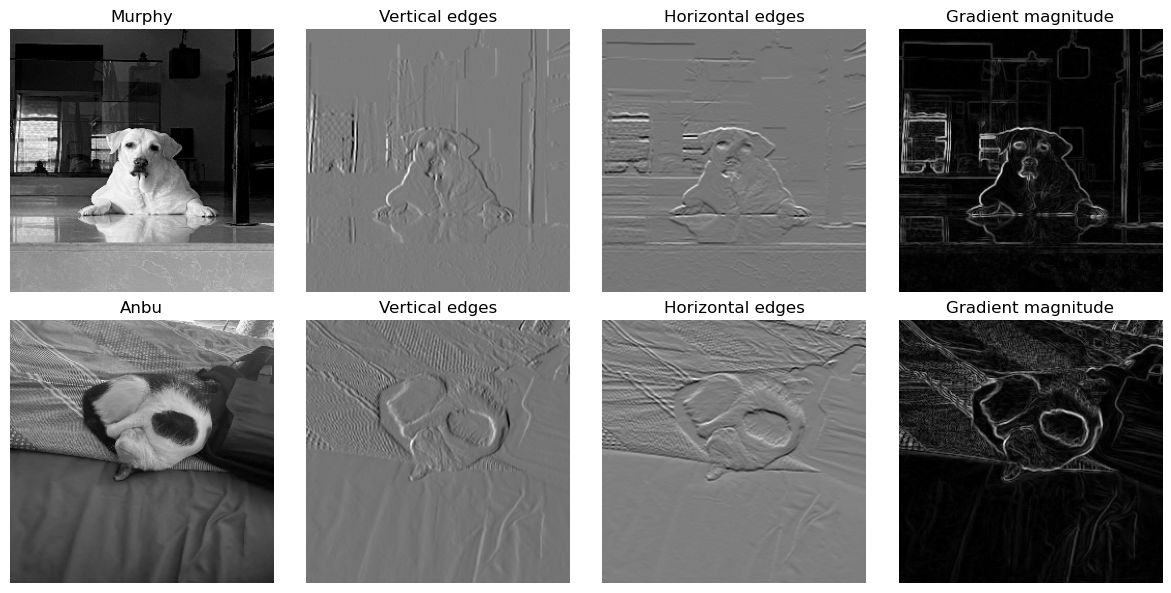

In [18]:
# Plot the original image and the convolution result (4 in a row)
fig, ax = plt.subplots(2, 4, figsize=(12,6))

for i, (img, title) in enumerate(zip([murphy_grayscale, murphy_v, murphy_h, murphy_vh], ['Murphy', 'Vertical edges', 'Horizontal edges', 'Gradient magnitude'])):
    ax[0, i].imshow(img.squeeze().detach().numpy(), cmap='gray')
    ax[0, i].set_title(title)
    ax[0, i].axis('off')
for i, (img, title) in enumerate(zip([anbu_grayscale, anbu_v, anbu_h, anbu_vh], ['Anbu', 'Vertical edges', 'Horizontal edges', 'Gradient magnitude'])):
    ax[1, i].imshow(img.squeeze().detach().numpy(), cmap='gray')
    ax[1, i].set_title(title)
    ax[1, i].axis('off')
plt.tight_layout()
plt.show()

## Pooling

A key component in the architecture of a CNN is the *pooling layer*, which is used to reduce the spatial dimensions of the input image while retaining the important features. There are two specifications the go into defining the pooling operation:
1. **Size of the pooling filter**: This is the size of the sub-region of the image that the pooling operation is applied to. Common choices are 2x2 or 3x3. Each region of this shape will be compressed into a single pixel in the output image. One way to execute this is to average out the pixel intensities in the sub-region, which is called **average pooling**. The other (more common) method is to take the maximum pixel intensity in the sub-region, which is called **max pooling**. In fact, this operation is not linear, so it is not actually a convolution operation!
2. **Stride**: This is the number of pixels by which the pooling filter is moved across the image. A stride of 1 means that the filter is moved one pixel at a time, while a stride of 2 means that the filter is moved two pixels at a time. For example, suppose we use a 2x2 pooling filter with stride 2. Then, the first sub-region of the image that the filter is applied to is the top-left 2x2 square of pixels. Then, we slide it two pixels to the right to get the next 2x2 square of pixels, and so on.

**Remark**: When applying convolutional layers to images, it is common to use a stride of 1, which means that the filter is moved one pixel at a time. Note that if a stride of $k$ is used, then the output image will have dimensions that are $\frac{1}{k}$ times the dimensions of the input image.

Let's implement this below by down-sampling the grayscale images of Murphy and Anbu using max pooling with a 2x2 filter and stride 2. We use the original large images for clarity.

In [ ]:
# # Apply the filter to the images
# murphy_grayscale = F.conv2d(murphy_tensor, avg_filter)
# anbu_grayscale = F.conv2d(anbu_tensor, avg_filter)

# Apply max pooling to the images; second argument is the stride
murphy_pool = F.max_pool2d(murphy_tensor, kernel_size=2, stride= 2)
anbu_pool = F.max_pool2d(anbu_tensor, kernel_size=2, stride= 2)

# Pool again to reduce the size further
murphy_pool2 = F.max_pool2d(murphy_pool, kernel_size=2, stride= 2)
anbu_pool2 = F.max_pool2d(anbu_pool, kernel_size=2, stride= 2)

# And one last time
murphy_pool3 = F.max_pool2d(murphy_pool2, kernel_size=2, stride= 2)
anbu_pool3 = F.max_pool2d(anbu_pool2, kernel_size=2, stride= 2)

In [ ]:
# display the original grayscale images along with the pooled images (4 per row)
fig, ax = plt.subplots(2, 4, figsize=(12,6))

for i, (img, title) in enumerate(zip([murphy_tensor, murphy_pool, murphy_pool2, murphy_pool3],
                                      ['Murphy', 'Pooled 1', 'Pooled 2', 'Pooled 3'])):
    im = img.squeeze()
    ax[0, i].imshow(im.permute(1, 2, 0))
    shape = img.shape  # expecting shape: [N, C, H, W] or [1, H, W]
    ax[0, i].set_title(f"{title} ({shape[-2]}, {shape[-1]})")
    ax[0, i].axis('off')
for i, (img, title) in enumerate(zip([anbu_tensor, anbu_pool, anbu_pool2, anbu_pool3],
                                      ['Anbu', 'Pooled 1', 'Pooled 2', 'Pooled 3'])):
    im = img.squeeze()
    ax[1, i].imshow(im.permute(1, 2, 0))
    shape = img.shape
    ax[1, i].set_title(f"{title} ({shape[-2]}, {shape[-1]})")
    ax[1, i].axis('off')
plt.tight_layout()
plt.show()

The above images exhibit the powerful feature of max pooling: it retains the important features of the image while reducing the spatial dimensions. This is crucial for reducing model complexity and guarding against overfitting.

### Dealing with edges and corners
One of the main issues with convolutions is that they can't be applied to the edges of the image, since the filter would "hang off" the edge. There are a few ways to deal with this:
1. **Valid padding**: In this case, the filter is only applied to the parts of the image where the filter fits entirely. This means that the output image will have smaller dimensions than the input image. This is the default behavior in PyTorch.
2. **Same padding**: In this case, the filter is applied to the entire image, and the missing parts are filled in with zeros. (So, we extend the image with zeroes till infinity and beyond.) 
This means that the output image will have the same dimensions as the input image, which is useful when we want to retain the spatial dimensions of the image.
3. **Reflect padding**: In this case, the filter is applied to the entire image, and the missing parts are filled in by reflecting the image at the edges. This is useful when we want to avoid the "black border" that comes from zero padding.
4. **Circular padding**: In this case, the filter is applied to the entire image, and the missing parts are filled in by wrapping the image around itself. This is useful when we want to avoid the "black border" that comes from zero padding.

Let's quickly illustrate all four types of padding on the grayscale image of Murphy.

In [ ]:
# Define a vertical Prewitt filter (for vertical edge detection)
prewitt_filter = torch.tensor([[1, 0, -1],
                               [1, 0, -1],
                               [1, 0, -1]], dtype=torch.float32)
# Reshape to [out_channels, in_channels, height, width]
prewitt_filter = prewitt_filter.view(1, 1, 3, 3)

# Define different padding modes to visualize
padding_modes = {
    'constant': 'constant',    # zero padding
    'reflect': 'reflect',
    'replicate': 'replicate',
    'circular': 'circular'
}

# Create a figure to display the results
fig, axes = plt.subplots(1, len(padding_modes) + 1, figsize=(15, 3))

# Without any padding (normal convolution)
conv_no_pad = F.conv2d(murphy_grayscale, prewitt_filter, padding=0)
axes[0].imshow(conv_no_pad.squeeze().detach().numpy(), cmap='gray')
axes[0].set_title(f'No Padding ({conv_no_pad.shape[-2]}x{conv_no_pad.shape[-1]})')
axes[0].axis('off')

# Loop over each padding mode. For a 3x3 filter, adding a padding of 1 yields "same" convolution.
for ax, (mode_label, mode) in zip(axes[1:], padding_modes.items()):
    
    # Pad the grayscale image using the current padding mode.
    # Here, pad=(1, 1, 1, 1) adds 1 pixel of padding to each side,
    # ensuring that a 3x3 convolution produces an output of the same spatial size.
    padded_img = F.pad(murphy_grayscale, pad=(1, 1, 1, 1), mode=mode)
    
    # Apply the vertical Prewitt filter on the padded image.
    # Note: padding=0 in conv2d because we've already padded the image manually.
    conv_padded = F.conv2d(padded_img, prewitt_filter, padding=0)
    ax.imshow(conv_padded.squeeze().detach().numpy(), cmap='gray')
    ax.set_title(f"{mode_label.capitalize()} ({conv_padded.shape[-2]}x{conv_padded.shape[-1]})")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Detecting hand-written digits in the MNIST dataset
Now that we have a good understanding of convolutions and pooling, let's apply this knowledge to a real-world problem: detecting hand-written digits in the MNIST dataset. The MNIST dataset consists of 28x28 grayscale images of hand-written digits from 0 to 9. The task is to classify each image into one of the 10 classes (0 to 9).

Before any CNN business, we need to process the images.

1. MNIST images are provided as 28×28 pixel grayscale images. Their initial shape is `(height, width) = (28, 28)`.
2. After `transforms.ToTensor()`, the shape of the image becomes `(C, H, W) = (1, 28, 28)`. This is because the `ToTensor()` transform converts the image to a PyTorch tensor and also scales the pixel values to lie in the range `[0, 1]`.
3. After `transforms.Normalize((0.1307,), (0.3081,))`, the pixel values are normalized by subtracting the mean `0.1307` and dividing by the standard deviation `0.3081`. This is a common normalization step in deep learning, as it helps the model learn better. However, this operation does not change the shape of the tensor. The final processed image remains with shape `(1, 28, 28)`.
4. The MNIST dataset is split into two parts: a training set and a test set. The training set is used to train the model, while the test set is used to evaluate the model's performance on unseen data. The training set contains 60,000 images, while the test set contains 10,000 images.

In [ ]:
# Define the pre-processing steps for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # convert images to tensors
    transforms.Normalize((0.1307,), (0.3081,))  # normalize the dataset
])

# Load MNIST train and test sets from the data folder
mnist_train = MNIST(root='assets/data', train=True, download=False, transform=transform)
mnist_test = MNIST(root='assets/data', train=False, download=False, transform=transform)

We use the folllowing architecture for our CNN:
Let's assume the input tensor represents a batch of MNIST images with shape `(N, 1, 28, 28)`, where N is the batch size.

1. **First Convolutional Layer (`conv1`):**  
   - **Input:** `(N, 1, 28, 28)`  , where `N` is the batch size.
   - This layer uses 16 filters of size 3×3 with padding=1. Padding of 1 preserves the spatial dimensions.  
   - **Output after `conv1`:** `(N, 16, 28, 28)`  
   - A ReLU activation is applied, but it does not change the tensor shape.
   - There are $16 * 3 * 3 = 144$ learnable weights in this layer.

2. **First Pooling Layer (`pool` after `conv1`):**  
   - **Input:** `(N, 16, 28, 28)`  
   - The max pooling layer uses a kernel size of 2 and stride 2, which halves the spatial dimensions.  
   - **Output after pooling:** `(N, 16, 14, 14)`

3. **Second Convolutional Layer (`conv2`):**  
   - **Input:** `(N, 16, 14, 14)`  
   - This layer uses 32 filters of size 3×3 with padding=1, preserving the spatial dimensions.  
   - **Output after `conv2`:** `(N, 32, 14, 14)`  
   - Again, applying ReLU does not change the shape.
   - There are $32 * 3 * 3 = 288$ learnable weights in this layer.

4. **Second Pooling Layer (`pool` after `conv2`):**  
   - **Input:** `(N, 32, 14, 14)`  
   - With the same 2×2 kernel and stride 2, this pooling operation further halves the spatial dimensions.  
   - **Output after pooling:** `(N, 32, 7, 7)`

5. **Flattening:**  
   - **Input:** `(N, 32, 7, 7)`  
   - This tensor is flattened into a vector for each example. The total number of features per image is `32 * 7 * 7 = 1568`.  
   - **Output after flattening:** `(N, 1568)`

6. **First Fully Connected Layer (`fc1`):**  
   - **Input:** `(N, 1568)`  
   - This layer maps the 1568 features to 128 neurons using an affine map following by ReLU.  
   - **Output:** `(N, 128)`  
   - There are $1568 * 128 + 128 = 200,832$ learnable weights in this layer.

7. **Second Fully Connected Layer (`fc2`):**  
   - **Input:** `(N, 128)`  
   - This final layer maps the 128 features to 10 outputs (one per digit class 0-9).  
   - **Output:** `(N, 10)`
   - There are $128 * 10 + 10 = 1,290$ learnable weights in this layer.

Thus, as data flows through the network, the tensor shapes change as follows:

- Input: `(N, 1, 28, 28)`  
- After `conv1` + ReLU: `(N, 16, 28, 28)`  
- After first pooling: `(N, 16, 14, 14)`  
- After `conv2` + ReLU: `(N, 32, 14, 14)`  
- After second pooling: `(N, 32, 7, 7)`  
- After flattening: `(N, 1568)`  
- After `fc1` + ReLU: `(N, 128)`  
- After `fc2`: `(N, 10)`

In total, the network has
\begin{equation*}
    144 + 288 + 200832 + 1290 = 202,554
\end{equation*}
weights! 

Notice that the vast majority of them are in the fully connected layers. This pattern typically holds also for other kinds of architectures (like transformers); the special sauce in the architecture extracts features in some manner, and then one hits the extracted features with fully connected layers and hope that it is smart enough to make the right predictions.

In [ ]:
# Define a simple CNN model for MNIST classification
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, # 1 input channel (grayscale)
                               out_channels=16, # 16 output channels (feature maps)
                               kernel_size=3, 
                               padding=1 # to preserve image dimensions
                               ) 
        self.conv2 = nn.Conv2d(in_channels=16, # 16 input channels (previous feature maps)
                               out_channels=32, # 32 output channels (new, fancier feature maps)
                               kernel_size=3, 
                               padding=1 # to preserve image dimensions
                               )  
        self.pool = nn.MaxPool2d(kernel_size=2, # Replace 2x2 grid of values with max value
                                 stride=2 # Shift by 2 pixels, results in halving spatial dims
                                 )  
        # 1st Fully connected layer
        # Input: flattened vector of 32 feature maps of size 7x7 (32*7*7 length in total)
        self.fc1 = nn.Linear(32 * 7 * 7, 128) # output: 128 features
        # 2nd Fully connected layer 
        self.fc2 = nn.Linear(128, 10)  # Output layer (10 classes for digits 0-9)

    def forward(self, x):
        x = self.conv1(x) # first Convolution
        x = F.relu(x) # ReLU activation
        x = self.pool(x) # first Pooling
        x = self.conv2(x) # second Convolution
        x = F.relu(x) # ReLU activation
        x = self.pool(x) # second Pooling
        x = x.view(-1, 32 * 7 * 7)  # Flatten
        x = self.fc1(x)  # first fully connected layer
        x = F.relu(x) # ReLU activation
        x = self.fc2(x) # output layer
        return x # Output layer (logits for 10 classes)

In [ ]:
# Initialize model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

# Training loop
num_epochs = 10
loss_history = []

for epoch in range(num_epochs):
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

In [ ]:
# Plot training loss evolution
plt.figure(figsize=(6, 4))
plt.plot(loss_history, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Evolution on MNIST")
plt.show()

In [ ]:
# Evaluate on test set
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

In [ ]:
# Visualize test classification results
fig, axes = plt.subplots(1, 5, figsize=(10, 5))
for i in range(5):
    sample_image, sample_label = mnist_test[i]
    sample_image = sample_image.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        output = model(sample_image)
        predicted_label = torch.argmax(output, dim=1).item()

    axes[i].imshow(sample_image.squeeze(0).squeeze(0), cmap="gray")
    axes[i].set_title(f"True: {sample_label}, Pred: {predicted_label}")
for ax in axes.flat:
    ax.axis("off")

plt.show()

# 5. AlexNet architecture (2012)

One of the key turning points for CNNs (and neural networks in general) was the development of AlexNet in 2012, by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton. This was the first deep CNN to win the ImageNet Large Scale Visual Recognition Challenge, which is a prestigious competition in the field of computer vision. AlexNet was able to achieve a top-5 error rate of 15.3%, destroyed the 26.2% achieved by the second-place entry.

Here is a  summary of the type of layers found in the famous AlexNet architecture:

Below is a detailed description of the layers in AlexNet, including the layer types, kernel sizes, strides, and other relevant details:

1. **Convolutional Layer 1:**  
   - **Type:** Convolutional  
   - **Filters:** 96  
   - **Kernel Size:** 11×11  
   - **Stride:** 4  
   - **Padding:** Typically no padding (or minimal) so that the receptive field is large.  
   - **Additional Operations:** Followed by ReLU activation, Local Response Normalization (LRN), and then max pooling.

2. **Pooling Layer 1:**  
   - **Type:** Max Pooling  
   - **Kernel Size:** 3×3  
   - **Stride:** 2  
   - **Purpose:** Reduces spatial dimensions and provides translation invariance.

3. **Convolutional Layer 2:**  
   - **Type:** Convolutional (split into 2 groups to distribute across GPUs in the original implementation)  
   - **Filters:** 256  
   - **Kernel Size:** 5×5  
   - **Stride:** 1  
   - **Padding:** 2 (to preserve spatial dimensions)  
   - **Additional Operations:** Followed by ReLU, LRN, and max pooling.

4. **Pooling Layer 2:**  
   - **Type:** Max Pooling  
   - **Kernel Size:** 3×3  
   - **Stride:** 2  
   - **Purpose:** Further spatial dimensionality reduction.

5. **Convolutional Layer 3:**  
   - **Type:** Convolutional  
   - **Filters:** 384  
   - **Kernel Size:** 3×3  
   - **Stride:** 1  
   - **Padding:** 1 (to preserve spatial dimensions)  
   - **Additional Operations:** Followed by ReLU activation.

6. **Convolutional Layer 4:**  
   - **Type:** Convolutional (again split into 2 groups)  
   - **Filters:** 384  
   - **Kernel Size:** 3×3  
   - **Stride:** 1  
   - **Padding:** 1  
   - **Additional Operations:** Followed by ReLU activation.

7. **Convolutional Layer 5:**  
   - **Type:** Convolutional (split into 2 groups)  
   - **Filters:** 256  
   - **Kernel Size:** 3×3  
   - **Stride:** 1  
   - **Padding:** 1  
   - **Additional Operations:** Followed by ReLU activation and then a max pooling layer.

8. **Pooling Layer 3:**  
   - **Type:** Max Pooling  
   - **Kernel Size:** 3×3  
   - **Stride:** 2  
   - **Purpose:** Reduces spatial dimensions before transitioning to fully connected layers.

9. **Fully Connected Layer 1:**  
   - **Type:** Fully Connected (Dense)  
   - **Neurons:** 4096  
   - **Additional Operations:** Followed by ReLU activation and Dropout for regularization.

10. **Fully Connected Layer 2:**  
    - **Type:** Fully Connected (Dense)  
    - **Neurons:** 4096  
    - **Additional Operations:** Followed by ReLU activation and Dropout for regularization.

11. **Fully Connected Layer 3 (Output Layer):**  
    - **Type:** Fully Connected (Dense)  
    - **Neurons:** 1000  
    - **Purpose:** Produces the class scores for ImageNet classification.

AlexNet's architecture incorporates several key design elements for effective feature extraction:

- **Increasing Number of Filters:**  
  As we progress deeper into the network, the number of filters increases. This allows the network to capture a growing variety of features and more complex patterns. Early layers detect simple features (e.g., edges and textures), while deeper layers combine these into higher-level representations.

- **Decreasing Kernel Sizes:**  
  The kernel size tends to decrease in later layers (from larger windows in early layers to smaller ones later) as the network focuses on fine-tuning and combining features from earlier layers. Smaller kernels can capture local details and enable the network to achieve higher resolution in the learned features, while larger kernels in early layers cover broader regions.

- **Spatial Reduction:**  
  Pooling layers and the use of strides in convolutional layers progressively reduce the spatial dimensions of the feature maps. This helps reduce computational complexity and allows the fully connected layers at the end of the network to operate on a manageable number of features.

- **Hierarchical Feature Learning:**  
  The combination of convolutional and pooling layers supports a hierarchical feature extraction process. Lower layers capture basic patterns, and as we move to higher layers, the network learns more abstract representations, effectively mimicking the visual processing hierarchy in the human visual system.

The final fully connected layers in AlexNet serve several key purposes:

- **Integration of Features:**  
  The fully connected layers take the high-level feature maps extracted by the convolutional and pooling layers and integrate these features. They combine all of the learned local information into a global understanding of the image.

- **Decision Making:**  
  Acting like a traditional neural network (multilayer perceptron), these layers perform the final steps of "reasoning" on the consolidated features. They map the learned representations to class scores by applying learned weights and biases.

- **Non-linear Transformation:**  
  Each fully connected layer is typically followed by a non-linear activation function (e.g., ReLU), which helps the network learn complex, non-linear decision boundaries.

- **Output Generation:**  
  The very last fully connected layer produces output neurons corresponding to the number of classes (e.g., 1000 for ImageNet), which are then often processed by a softmax function to generate probabilistic class predictions.

In [ ]:
# import os
import json
# import urllib.request

# Define the path to the parent folder of the current notebook
# parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
# json_filename = os.path.join(parent_dir, 'imagenet_class_index.json')

# # If the file doesn't exist in the parent folder, download it there.
# if not os.path.exists(json_filename):
#     url = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
#     print("Downloading 'imagenet_class_index.json' to the parent folder...")
#     urllib.request.urlretrieve(url, json_filename)
#     print("Download complete.")

# Load ImageNet class labels from the JSON file in the same folder as the notebook
with open('assets/imagenet_class_index.json') as f:
    class_idx = {int(key): value[1] for key, value in json.load(f).items()}
class_idx

In [ ]:
# Load the pretrained AlexNet model
from torchvision.models import alexnet, AlexNet_Weights
alexnet = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
alexnet.eval()

# Define the preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize(256),             # Resize the shorter side to 256 pixels
    transforms.CenterCrop(224),         # Crop a 224x224 region from the center
    transforms.ToTensor(),              # Convert PIL image to Tensor
    transforms.Normalize(               # Normalize using ImageNet's mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def classify_image(image_path, model, preprocess, idx2label):
    # Open the image and ensure it is in RGB mode
    img = PILImage.open(image_path).convert('RGB')
    # Preprocess the image
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

    # Get the model predictions without computing gradients
    with torch.no_grad():
        output = model(input_batch)

    # Compute probabilities and get the top predicted class
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    top_prob, top_idx = probabilities.topk(1)
    predicted_label = class_idx[top_idx.item()]
    return predicted_label, top_prob.item()

In [ ]:
# List of pet image filenames (ensure these images are in the same directory or adjust the paths)
pet_images = ['assets/murphy.jpeg', 'assets/anbu.jpeg']

fig, axes = plt.subplots(1, len(pet_images), figsize=(10, 5))
for ax, image_path in zip(axes, pet_images):
    label, probability = classify_image(image_path, alexnet, preprocess, class_idx)
    print(f"Image: {image_path}, Predicted label: {label}, Probability: {probability:.4f}")
    
    img = PILImage.open(image_path)
    ax.imshow(img)
    ax.set_title(f"Predicted: {label}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Load the pretrained ResNet model
from torchvision.models import resnet18, ResNet18_Weights
resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet.eval()

fig, axes = plt.subplots(1, len(pet_images), figsize=(10, 5))
for ax, image_path in zip(axes, pet_images):
    label, probability = classify_image(image_path, resnet, preprocess, class_idx)
    print(f"Image: {image_path}, Predicted label: {label}, Probability: {probability:.4f}")
    
    img = PILImage.open(image_path)
    ax.imshow(img)
    ax.set_title(f"Predicted: {label}")
    ax.axis('off')
plt.tight_layout()
plt.show()

Lol, AlexNet thinks Anbu is a giant panda, and ResNet thinks she is a Chickadee. For reference, here is a picture of a Chickadee (once you see it, you can forgive ResNet because the resemblance is uncanny):

In [ ]:
display(Image('assets/chickadee-indiana-audubon.jpg'))